In [1]:
!jupyter notebook --version

6.5.2


In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1+cu117 --user -f https://download.pytorch.org/whl/cu117/torch_stable.html

In [2]:
import pandas as pd

In [3]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer,RobertaTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from transformers import RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer

df = pd.read_csv('C:/Users/JenMing/Desktop/MBTI/one_type_one_sentence/mbti_to_DF_otos.csv')
df.head()

,type,posts
0,INFJ,What has been the most life-changing experienc...
1,INFJ,May the PerC Experience immerse you.
2,INFJ,Hello certain personality7. Sorry to hear of y...
3,INFJ,Welcome and stuff.
4,INFJ,"Prozac, wellbrutin, at least thirty minutes of..."


In [4]:
# 檢查是否有可用的GPU
print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

True
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [5]:
torch.cuda.empty_cache()

In [6]:
df['type'].value_counts()

INFP    82817
INFJ    67008
INTP    58539
INTJ    48882
ENTP    31797
ENFP    30899
ISTP    15190
ISFP    11833
ENTJ    10578
ISTJ     9186
ENFJ     8748
ISFJ     7484
ESTP     4046
ESFP     2067
ESFJ     1957
ESTJ     1816
Name: type, dtype: int64

In [7]:
possible_labels = df.type.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'INFJ': 0,
 'ENTP': 1,
 'INTP': 2,
 'INTJ': 3,
 'ENTJ': 4,
 'ENFJ': 5,
 'INFP': 6,
 'ENFP': 7,
 'ISFP': 8,
 'ISTP': 9,
 'ISFJ': 10,
 'ISTJ': 11,
 'ESTP': 12,
 'ESFP': 13,
 'ESTJ': 14,
 'ESFJ': 15}

In [8]:
df['label'] = df.type.replace(label_dict)

In [9]:
type_index_mapping = {
    'ESTJ': '0000',
    'ISTJ': '1000',
    'INTJ': '1100',
    'INFJ': '1110',
    'INFP': '1111',
    'INTP': '1101',
    'ISTP': '1001',
    'ISFJ': '1010',
    'ISFP': '1011',
    'ESTP': '0001',
    'ESFJ': '0010',
    'ESFP': '0011',
    'ENTJ': '0100',
    'ENFP': '0111',
    'ENTP': '0101',
    'ENFJ': '0110'
}

df['type_index'] = df['type'].replace(type_index_mapping)

In [10]:
df.head()

,type,posts,label,type_index
0,INFJ,What has been the most life-changing experienc...,0,1110
1,INFJ,May the PerC Experience immerse you.,0,1110
2,INFJ,Hello certain personality7. Sorry to hear of y...,0,1110
3,INFJ,Welcome and stuff.,0,1110
4,INFJ,"Prozac, wellbrutin, at least thirty minutes of...",0,1110


In [11]:
from sklearn.model_selection import train_test_split

#在資料集裡面, 我們會選取特徵 (就是"x") , 對應特徵的部分, 會有 Label (標記), (就是"y")
# 假设 df 包含特征 'X' 和标签 'label'
X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.3, random_state=42, stratify=df['label'].values)

# 进一步划分剩余的数据为验证集和测试集
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#old
#df['data_type'] = ['not_set']*df.shape[0]

#df.loc[X_train, 'data_type'] = 'train'
#df.loc[X_val, 'data_type'] = 'val'

#df.groupby(['type', 'label', 'data_type']).count()

# 假設的 y_train 數據，因為原始數據未提供
y_train = np.random.choice(['Type1', 'Type2'], 100, p=[0.9, 0.1])

# 轉換為 pandas Series
y_train_pd = pd.Series(y_train)

# 生成圓餅圖
plt.figure(figsize=(10, 6))
y_train_pd.value_counts().plot(kind='pie', colors=['lightcoral', 'skyblue'], autopct='%1.2f%%', explode=[0, 0.1])
plt.title('MBTI')  # 圖標題
plt.ylabel('')  # 移除 y 軸標籤

# 將圖例顯示在圖表旁邊
plt.legend(loc='best')

# 顯示圖表
plt.show()

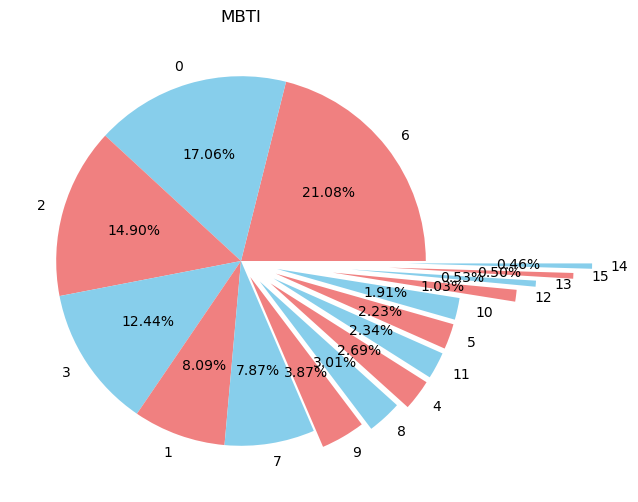

In [49]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,6) )
y_train_pd = pd.Series(y_train)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%',explode = [0, 0, 0, 0, 0, 0, 0.1, 0.15, 0.2, 0.2, 0.2, 0.2, 0.5, 0.6, 0.8, 0.9])
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [13]:
#上採樣
from imblearn.over_sampling import SMOTE
X_train_re = np.array(X_train).reshape(-1, 1)
y_train_re = np.array(y_train).reshape(-1, 1)
X_train_SM, y_train_SM = SMOTE().fit_resample(X_train_re, y_train_re)

X_val_re = np.array(X_val).reshape(-1, 1)
y_val_re = np.array(y_val).reshape(-1, 1)
X_val_SM, y_val_SM = SMOTE().fit_resample(X_val_re, y_val_re)

#X_test_re = np.array(X_test).reshape(-1, 1)
#y_test_re = np.array(y_test).reshape(-1, 1)
#X_test_SM, y_test_SM = SMOTE().fit_resample(X_test_re, y_test_re)

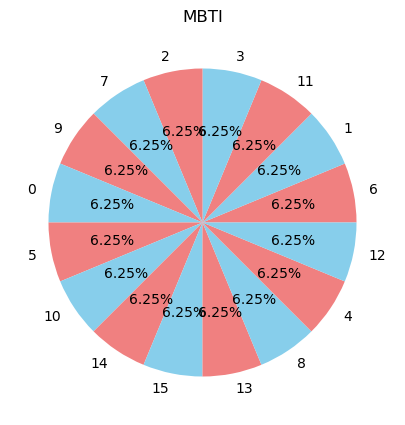

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train_pd = pd.Series(y_train_SM)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [15]:
#下採樣
from imblearn.under_sampling import TomekLinks
X_train_res, y_train_res = TomekLinks().fit_resample(X_train_SM, y_train_SM)
X_val_res, y_val_res = TomekLinks().fit_resample(X_val_SM, y_val_SM)
#X_test_res, y_test_res = TomekLinks().fit_resample(X_test_SM, y_test_SM)

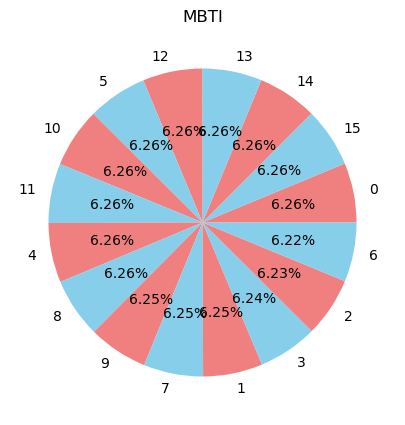

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train_pd = pd.Series(y_train_res)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [17]:
c

posts  type_index
type label data_type                   
ENFJ 5     not_set      106         108
           train       3645        3647
           val         4990        4993
ENFP 7     not_set     2211        2224
           train      19632       19658
           val         9012        9017
ENTJ 4     not_set      169         172
           train       4866        4868
           val         5536        5538
ENTP 1     not_set     2392        2399
           train      20259       20283
           val         9107        9115
ESFJ 15    not_set       13          13
           train        502         503
           val         1441        1441
ESFP 13    not_set       26          27
           train        548         550
           val         1490        1490
ESTJ 14    not_set       17          17
           train        390         391
           val         1407        1408
ESTP 12    not_set       28          30
           train       1251        1255
           val         2759        2761
INFJ 0     not_set     8827        8841
           train      46023       46086
           val        12062       12081
INFP 6     not_set    13469       13493
           train      57072       57132
           val        12172       12192
INTJ 3     not_set     5579        5598
           train      32746       32775
           val        10498       10509
INTP 2     not_set     7650        7673
           train      39779       39840
           val        11011       11026
ISFJ 10    not_set       88          91
           train       2885        2893
           val         4496        4500
ISFP 8     not_set      223         228
           train       5795        5810
           val         5792        5795
ISTJ 11    not_set      122         126
           train       3965        3976
           val         5084        5084
ISTP 9     not_set      401         405
           train       8062        8073
           val         6705        6712

In [18]:
# 删除包含空值的行
df = df.dropna(subset=['posts'])

In [19]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', 
#                                          do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].posts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].posts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt',
    truncation=True
)
'''
encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].posts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt',
    truncation=True
)
'''

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

#input_ids_test = encoded_data_test['input_ids']
#attention_masks_test = encoded_data_test['attention_mask']
#labels_test = torch.tensor(df[df.data_type=='test'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
#dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

C:\Users\JenMing\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
count = 0
for i, n in enumerate(df['posts']):
    if type(n) != str:
        count += 1
        print(f"非字符串值的索引：{i}")
print(f"共有 {count} 個非字符串值")

共有 0 個非字符串值


In [21]:
from transformers import BertConfig
import torch.nn as nn

#config = RobertaConfig.from_pretrained('roberta-base', num_labels=len(label_dict),output_attentions=False,
#                                                      output_hidden_states=False)
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(label_dict),output_attentions=False,
                                                      output_hidden_states=False)
config.hidden_dropout_prob = 0.1
config.attention_probs_dropout_prob = 0.1

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
#--- transformer ---
#import torch.nn as nn
# 获取BERT模型的输出维度
#hidden_size = model.config.hidden_size

#transformer_classifier = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=4)
#model.classifier = transformer_classifier
# --- LSTM ---
#import torch.nn as nn
#class LSTMClassifier(nn.Module):
#    def __init__(self, input_size, hidden_size, num_classes):
#        super(LSTMClassifier, self).__init__()
#        self.hidden_size = hidden_size
#        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#        self.fc = nn.Linear(hidden_size, num_classes)
#    def forward(self, x):
#        _, (h_n, _) = self.lstm(x)
#        output = self.fc(h_n[-1])
#        return output

#num_classes = 16
    
# 获取BERT模型的输出维度
#hidden_size = model.config.hidden_size

# 创建LSTM分类器
#lstm_classifier = LSTMClassifier(hidden_size, hidden_size, num_classes)

# 替换BERT模型的分类器为LSTM分类器
#model.classifier = lstm_classifier

#--- softmax ---

# 替換classifier的最後一層為一個全連接層
#num_classes = 16  # 目標類別數量
#model.classifier.out_proj = torch.nn.Linear(config.hidden_size, num_classes)
#model.classifier.dropout = torch.nn.Dropout(config.hidden_dropout_prob)

# 添加softmax層
#model.softmax = torch.nn.Softmax(dim=1)

#config = BertConfig(dropout=0.3)
#model = BertForSequenceClassification.from_pretrained("bert-large-uncased",
#                                                      num_labels=len(label_dict),
#                                                      output_attentions=False,
#                                                      output_hidden_states=False)

#import torch.nn as nn
# 修改 BERT 模型的最後一層
#model.classifier = nn.Sequential(
#    nn.Dropout(0.1),  # 新增 dropout 層
#    nn.Linear(model.config.hidden_size, len(label_dict)),  # 輸出層
#    nn.Softmax(dim=1)  # 新增 softmax 函數
#)

#---L2正則化---
# 添加L2正则化到模型的所有参数
#l2_reg = 0.01  # 调整正则化强度
# 在模型的参数中添加L2正则化项
#for name, param in model.named_parameters():
#    if 'bias' not in name:  # 排除偏置项
#        param.data = param.data.add(-l2_reg * param.data)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
print(torch.cuda.memory_allocated()/ 1073741824)
print(torch.cuda.max_memory_allocated()/ 1073741824)

print(f"Max memory of GPU 0: {torch.cuda.get_device_properties(0).total_memory / 1024**3} GB")

0.40896177291870117
0.40896177291870117
Max memory of GPU 0: 10.99969482421875 GB


In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 12

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

#dataloader_testing = DataLoader(dataset_test, 
#                                   sampler=SequentialSampler(dataset_test), 
#                                  batch_size=batch_size)


In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8,
                  correct_bias=False)
                  
epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

C:\Users\JenMing\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/ 1073741824)
print(torch.cuda.max_memory_allocated()/ 1073741824)

print(f"Max memory of GPU 0: {torch.cuda.get_device_properties(0).total_memory / 1024**3} GB")

0.40896177291870117
0.40896177291870117
Max memory of GPU 0: 10.99969482421875 GB


In [26]:
def accuracy_per_class_index(list_to_convert):
    index_mapping = {
        0: '1110',
        1: '0101',
        2: '1101',
        3: '1100',
        4: '0100',
        5: '0110',
        6: '1111',
        7: '0111',
        8: '1011',
        9: '1001',
        10: '1010',
        11: '1000',
        12: '0001',
        13: '0011',
        14: '0000',
        15: '0010'
    }

    # 將數字列表轉換為對應的MBTI類別列表
    index_map_list = [index_mapping[i] for i in list_to_convert]

    return index_map_list


In [27]:
def count_acc(preds,labels,d,r):
    preds_tmp = preds//d
    labels_tmp = labels//d
    preds_tmp = preds_tmp%r
    labels_tmp = labels_tmp%r
    if preds_tmp == labels_tmp:
        return True

In [28]:
def accuracy_per_class_pk(preds, labels, opt_save_dic, f):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    preds_convert = accuracy_per_class_index(preds_flat)
    labels_convert = accuracy_per_class_index(labels_flat)
    EI_count = 0
    SN_count = 0
    TF_count = 0
    JP_count = 0
    for n in range(len(preds_convert)):
        preds_tmp = int(preds_convert[n])
        labels_tmp = int(labels_convert[n])
        JP_count_bool = count_acc(preds_tmp,labels_tmp,1,10)
        if JP_count_bool == True:
            JP_count += 1
        TF_count_bool = count_acc(preds_tmp,labels_tmp,10,10)
        if TF_count_bool == True:
            TF_count += 1
        SN_count_bool = count_acc(preds_tmp,labels_tmp,100,10)
        if SN_count_bool == True:
            SN_count += 1    
        EI_count_bool = count_acc(preds_tmp,labels_tmp,1000,10)
        if EI_count_bool == True:
            EI_count += 1    

    print(f'E.I: {EI_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(EI_count/len(preds_convert))+'\n')
    print(f'S.N: {SN_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(SN_count/len(preds_convert))+'\n')
    print(f'T.F: {TF_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(TF_count/len(preds_convert))+'\n')
    print(f'J.P: {JP_count}/{len(preds_convert)}')
    print('Accuracy: '+ str(JP_count/len(preds_convert))+'\n')
    
    f.write(f'E.I: {EI_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(EI_count/len(preds_convert))+'\n')
    f.write(f'S.N: {SN_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(SN_count/len(preds_convert))+'\n')
    f.write(f'T.F: {TF_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(TF_count/len(preds_convert))+'\n')
    f.write(f'J.P: {JP_count}/{len(preds_convert)}\n')
    f.write('Accuracy: '+ str(JP_count/len(preds_convert))+'\n')

In [29]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, opt_save_dic):
    save_dic = opt_save_dic + 'output_acc.txt'
    f = open(save_dic, "w")
    count_acc  = 0
    count_total = 0
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label] #預測的
        y_true = labels_flat[labels_flat==label] #答案
        print(f'Class: {label_dict_inverse[label]}')
        f.write(f"Class: {label_dict_inverse[label]}\n")
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        f.write(f"Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n")
        count_acc += len(y_preds[y_preds==label])
        count_total += len(y_true)
    print(f'Total: {count_acc}/{count_total}\n')
    f.write(f"Total: {count_acc}/{count_total}\n")
    
    accuracy_per_class_pk(predictions, true_vals, opt_save_dic,f)
    f.close()

In [30]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
import random
import numpy as np

torch.cuda.empty_cache()
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
    
best_loss = float('inf') # 設定為無窮大
best_f1 = 0
patience = 8
counter = 0

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        
        # 添加L2正则化项
        l2_loss = 0.0
        #for name, param in model.named_parameters():
        #    if 'bias' not in name:
        #        l2_loss += 0.5 * l2_reg * torch.sum(param ** 2)
        
        total_loss = loss.item() + l2_loss
        loss_train_total += total_loss
        loss.backward()
        #total_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume_otos/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    #val_loss => loss_train_avg
    #if val_loss < best_loss:
    #    best_loss = val_loss
    #    counter = 0
    #    torch.save(model.state_dict(), 'data_volume/best_model.model')  # 保存最好的模型参数
    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model.state_dict(), 'data_volume_otos/best_model.model')  # 保存最好的模型参数
    else:
        counter += 1
        if counter >= patience:
            print("check")
            break
    print(counter)

In [32]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/ 1073741824)
print(torch.cuda.max_memory_allocated()/ 1073741824)

print(f"Max memory of GPU 0: {torch.cuda.get_device_properties(0).total_memory / 1024**3} GB")

1.6342501640319824
9.061946868896484
Max memory of GPU 0: 10.99969482421875 GB


In [ ]:
from transformers import BertConfig
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

#data_volume_1106_L2_Nsoftmax_bert-base_batch_size =12/

opt_save_dic = "data_volume_otos/"
model.load_state_dict(torch.load(opt_save_dic+'finetuned_BERT_epoch_8.model', map_location=torch.device('cuda')),strict=False)

for epoch in tqdm(range(9, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        
        # 添加L2正则化项
        l2_loss = 0.0
        #for name, param in model.named_parameters():
        #    if 'bias' not in name:
        #        l2_loss += 0.5 * l2_reg * torch.sum(param ** 2)
        
        total_loss = loss.item() + l2_loss
        loss_train_total += total_loss
        loss.backward()
        #total_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume_otos/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    #val_loss => loss_train_avg
    #if val_loss < best_loss:
    #    best_loss = val_loss
    #    counter = 0
    #    torch.save(model.state_dict(), 'data_volume/best_model.model')  # 保存最好的模型参数
    if val_f1 > best_f1:
        best_f1 = val_f1
        counter = 0
        torch.save(model.state_dict(), 'data_volume_otos/best_model.model')  # 保存最好的模型参数
    else:
        counter += 1
        if counter >= patience:
            print("check")
            break
    print(counter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/20619 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.7821703184005956
Validation loss: 3.9801459823474037
F1 Score (Weighted): 0.13919628262946615
2


Epoch 10:   0%|          | 0/20619 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.7810459676661138
Validation loss: 3.9801459823474037
F1 Score (Weighted): 0.13919628262946615
3


Epoch 11:   0%|          | 0/20619 [00:00<?, ?it/s]

In [ ]:
from transformers import BertConfig
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

#data_volume_1106_L2_Nsoftmax_bert-base_batch_size =12/

opt_save_dic = "data_volume_otos/"
model.load_state_dict(torch.load(opt_save_dic+'best_model.model', map_location=torch.device('cuda')),strict=False)
#finetuned_BERT_epoch_50
_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals, opt_save_dic)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predicted_labels = np.argmax(predictions, axis=1)

# 计算准确度
accuracy = accuracy_score(true_vals, predicted_labels)

# 计算精确度
precision = precision_score(true_vals, predicted_labels, average='weighted')

# 计算召回率
recall = recall_score(true_vals, predicted_labels, average='weighted')

# 计算F1分数
f1 = f1_score(true_vals, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [ ]:
# 设置待分析的句子
sentence = "Hello world!"
# 对句子进行分词和编码
encoded_inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt")
input_ids = encoded_inputs["input_ids"].to(device)
attention_mask = encoded_inputs["attention_mask"].to(device)

# 将模型设置为评估模式
model.eval()

# 运行模型的前向传播
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
# 获取模型的预测结果
logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1)

reversed_label_dict = {v: k for k, v in label_dict.items()}

# 使用预测的标签索引查找相应的类型
predicted_type = reversed_label_dict[predicted_labels.item()]

#label_dict
# 打印预测结果
print("Predicted type:", predicted_type)

# 打印预测结果
#print("Predicted label:", logits)

In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())

In [2]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.1
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binary